<a href="https://colab.research.google.com/github/Zuuru/Computer-Vision/blob/main/CVF3FIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zulfikri Arya Putra Ismail (4.33.24.2.15)

# JOBSHEET 03: TEKNIK REGRESI GAMBAR


## Praktikum

### Praktikum D1 – Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

#### 1)	Setup & Generator Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1)  # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)  # center-x
    cy = np.random.randint(r, img_size - r)  # center-y
    cv2.circle(img, (cx, cy), r, (255,), -1)  # lingkaran putih terisi
    img = (img / 255.0).astype(np.float32)
    # 3-channel biar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)


#### 2)	“Tebak Apa?” — Tampilkan Contoh Gambar TANPA Label

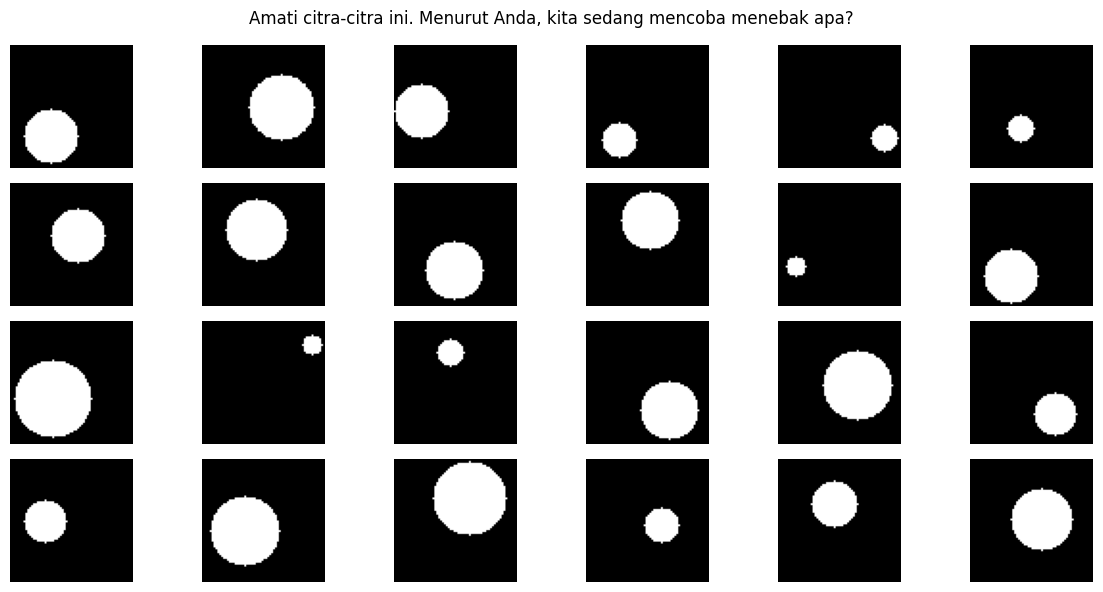

In [ ]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label:
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()


#### 3)	Buka Jawaban — Target yang Ingin Diprediksi

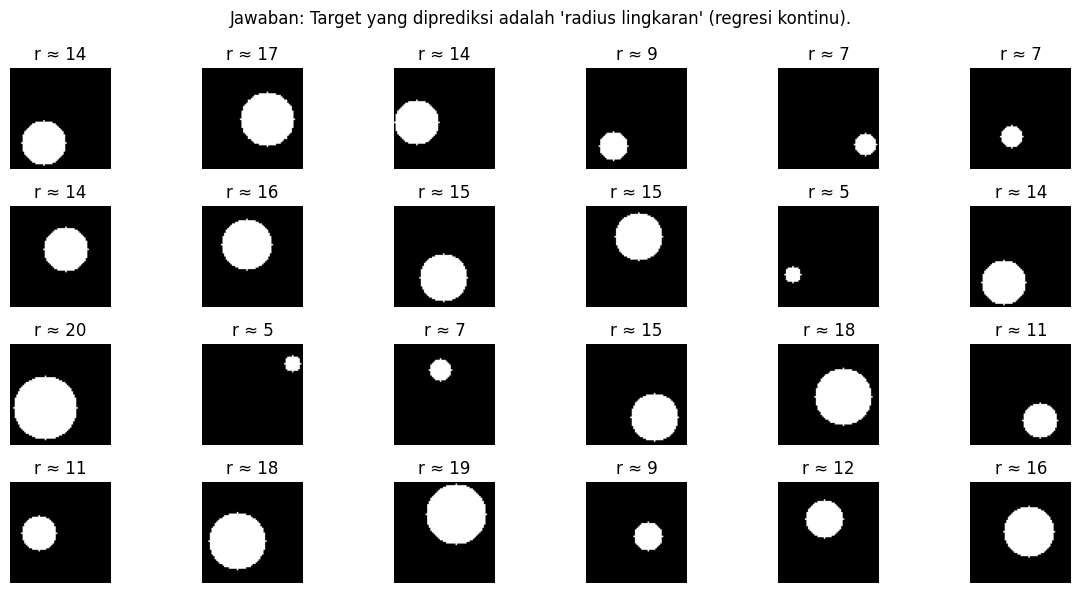

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()


#### 4)	(Opsional) Latih CNN Kecil untuk Memprediksi Radius

In [ ]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # output regresi
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=0)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
MAE=0.938 | RMSE=1.142 | R²=0.938


Plot history & True vs Predicted:

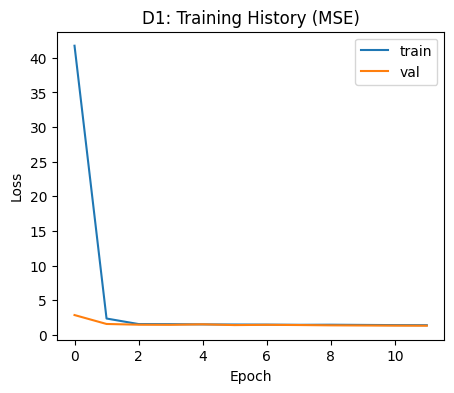

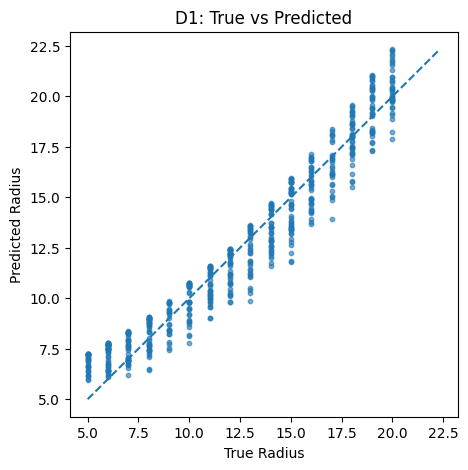

In [ ]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()


### Praktikum D2 – Menebak Umur Manusia dari Foto Wajah (UTKFace)

Langkah 1 — Membuat Akun Kaggle dan Mengunduh kaggle.json
Agar dapat mengakses dataset publik Kaggle, mahasiswa perlu membuat akun terlebih dahulu.
Ikuti langkah berikut:
1.	Buka situs https://www.kaggle.com

2.	Daftar menggunakan email Google atau GitHub.

3.	Setelah login, klik profil di kanan atas → pilih “Account”.

4.	Gulir ke bawah ke bagian API → klik “Create New API Token”.

5.	File bernama kaggle.json akan otomatis terunduh ke komputer Anda.

File ini berisi API key pribadi agar Colab bisa mengakses dataset Kaggle Anda.
Simpan file kaggle.json dengan baik (jangan dibagikan ke orang lain).


#### Langkah 2 — Mengunggah kaggle.json ke Colab

In [ ]:
# Jalankan ini di awal notebook
from google.colab import files
files.upload() # pilih file kaggle.json dari komputer Anda

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zuurukanaeru","key":"db132e2c8ec9f560527405dc82d25f46"}'}

Setelah diunggah, jalankan sel berikut untuk menyiapkan koneksi Kaggle:

In [ ]:
import os
import shutil

# Periksa apakah file kaggle.json ada di direktori saat ini
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip install -q kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("⚠️ File kaggle.json belum ditemukan. Silakan upload terlebih dahulu.")


✅ Kaggle API siap digunakan.


#### Langkah 3 — Mengunduh Dataset UTKFace dari Kaggle

In [ ]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


#### Langkah 4 — Menampilkan Contoh Gambar Dataset

Total gambar ditemukan: 23708


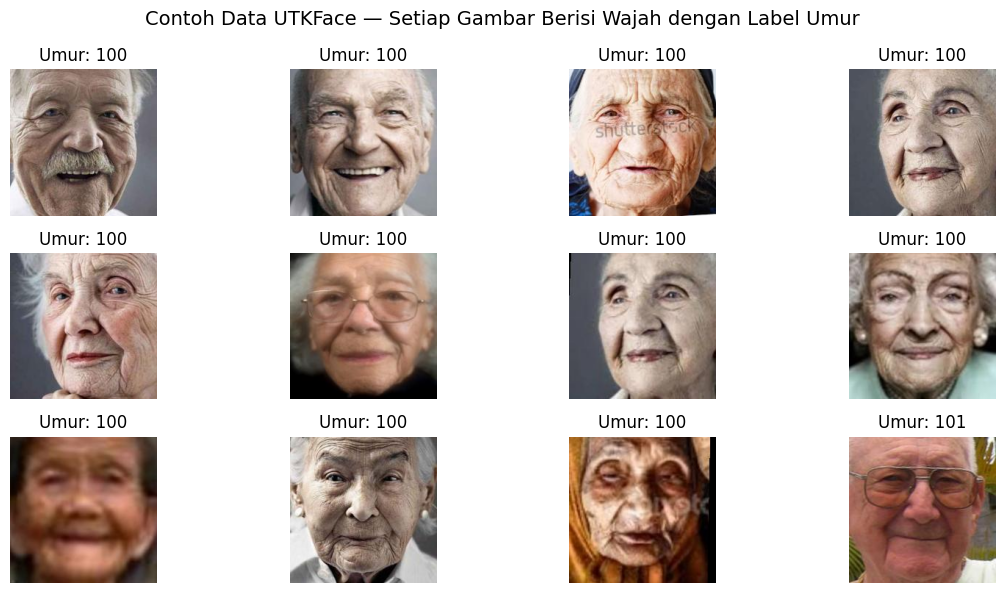

In [ ]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()


#### Langkah 5 — Siapkan Dataset untuk Model

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160
def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")


✅ Dataset siap dilatih.


#### Langkah 6 — Membangun Model dengan Transfer Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])

model.summary()


Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_4 (Multiply)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Langkah 7 — Melatih Model (Tahap 1 – Frozen)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 64s 126ms/step - loss: 337.8046 - mae: 13.4965 - val_loss: 163.0702 - val_mae: 9.8133 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 156.4498 - mae: 9.3172 - val_loss: 146.2384 - val_mae: 9.1180 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 142.8817 - mae: 8.8339 - val_loss: 142.6732 - val_mae: 8.9785 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 143.8334 - mae: 8.7850 - val_loss: 140.6937 - val_mae: 8.8974 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 138.0735 - mae: 8.6378 - val_loss: 137.0727 - val_mae: 8.7176 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 136.2602 - mae: 8.5257 - val_loss: 135.0265 - val_mae: 8.6030 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 131.6178 - mae: 8.4041 - val_loss: 133.1106 - va

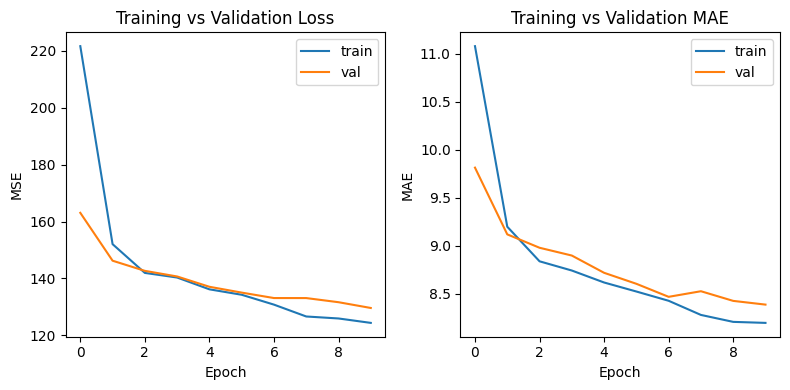

In [ ]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()


#### Langkah 8 — Fine-tuning Backbone (Tahap 2)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 52s 121ms/step - loss: 188.7909 - mae: 10.1183 - val_loss: 150.2679 - val_mae: 9.0394 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 56s 60ms/step - loss: 78.9345 - mae: 6.6207 - val_loss: 126.3244 - val_mae: 8.7060 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 51.3586 - mae: 5.3980 - val_loss: 111.6215 - val_mae: 7.8848 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 39.6290 - mae: 4.7791 - val_loss: 102.7948 - val_mae: 7.4952 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 30.1014 - mae: 4.1629 - val_loss: 111.8388 - val_mae: 7.9339 - learning_rate: 1.0000e-04


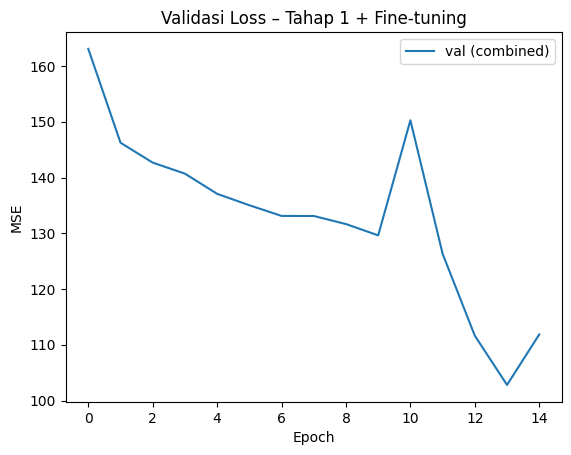

In [ ]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning:
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.show()


#### Langkah 9 — Evaluasi Akhir (MAE, RMSE, R²)

MAE  = 7.50 tahun
RMSE = 10.14 tahun
R²   = 0.741


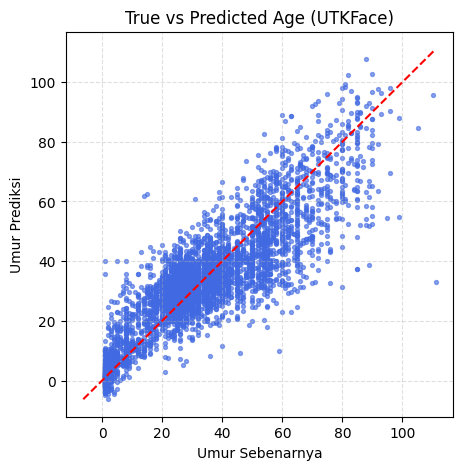

In [ ]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae  = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2   = r2_score(y_test, y_pred)

print(f"MAE  = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R²   = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


#### Langkah 10 — Melihat Contoh Prediksi Nyata

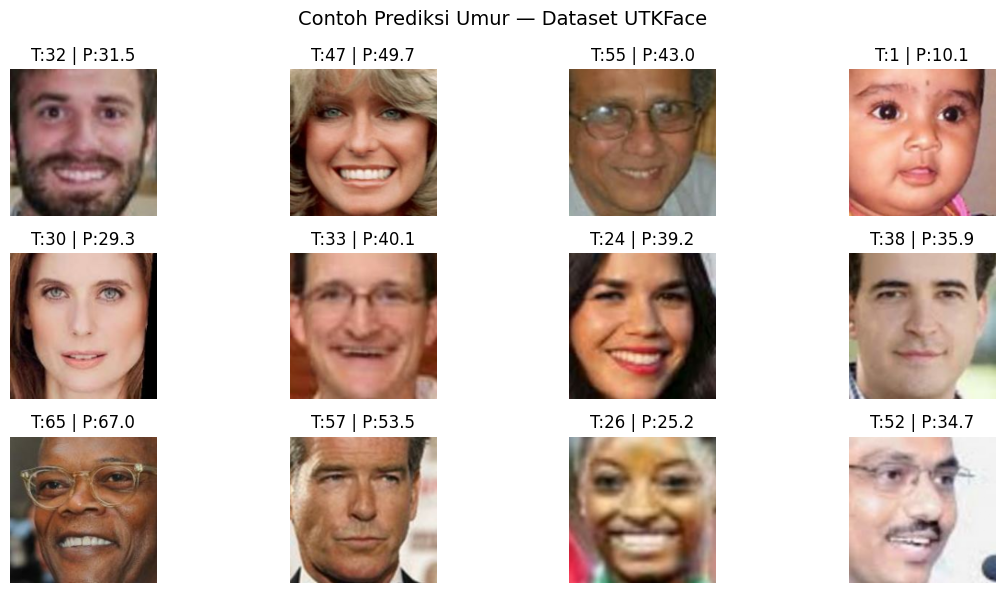

In [ ]:
import random

sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()


### Praktikum D3 — Menilai “Kepopuleran Hewan Peliharaan” dari Foto

#### Langkah 1 — Menyiapkan Kaggle API

In [ ]:
from google.colab import files

files.upload()  # pilih kaggle.json dari komputer Anda

import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("    kaggle.json belum ditemukan. Upload terlebih dahulu.")


Saving kaggle.json to kaggle (1).json
✅ Kaggle API siap digunakan.


#### Langkah 2 — Mengunduh dan Mengekstrak Dataset

In [ ]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")


✅ Dataset Pawpularity berhasil diekstrak.


#### Langkah 3 — Melihat Contoh Data

                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

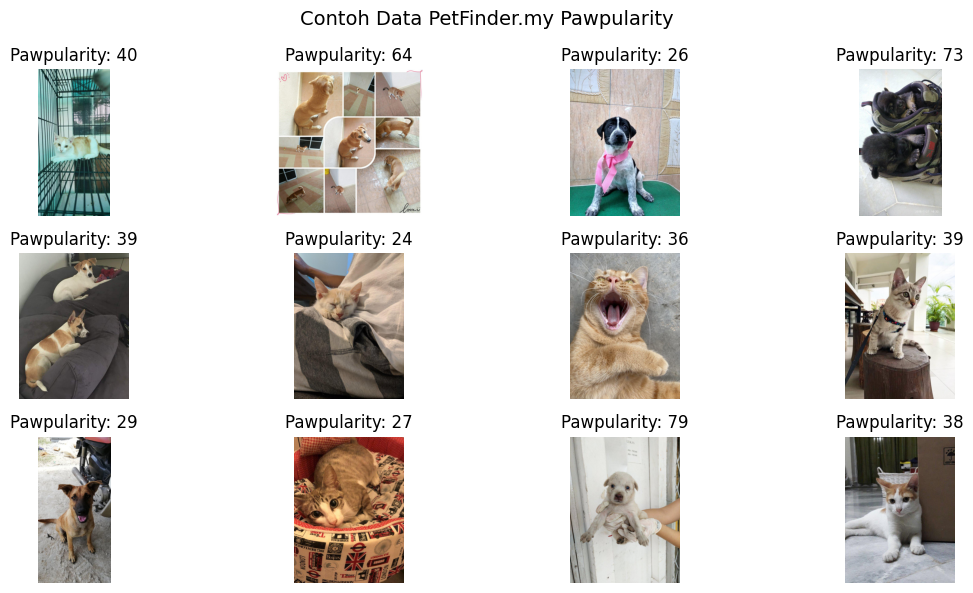

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')
plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


#### Langkah 4 — Persiapan Dataset

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")


Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


#### Langkah 5 — Membangun Model (EfficientNetB0)

In [ ]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False  # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

#### Langkah 6 — Melatih Model

In [ ]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=cb, verbose=1)


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 122s 651ms/step - loss: 850.4995 - mae: 21.9341 - val_loss: 485.5106 - val_mae: 16.3062 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 235ms/step - loss: 439.7861 - mae: 15.5615 - val_loss: 433.3813 - val_mae: 15.1873 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 203ms/step - loss: 390.9327 - mae: 14.7425 - val_loss: 408.9079 - val_mae: 14.8873 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 228ms/step - loss: 379.7911 - mae: 14.4904 - val_loss: 395.3270 - val_mae: 14.7474 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - loss: 342.1135 - mae: 13.7578 - val_loss: 384.8725 - val_mae: 14.3792 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 203ms/step - loss: 350.4217 - mae: 13.9115 - val_loss: 375.2744 - val_mae: 14.2788 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - loss: 347.0485 - mae: 13.8975 - val_

#### Langkah 7 — Melihat Proses Belajar

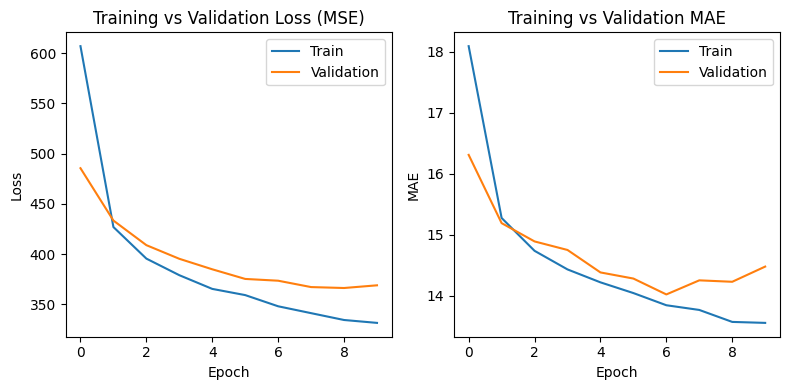

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()


#### Langkah 8 — Evaluasi Model


MAE  = 14.23
RMSE = 19.14
R²   = 0.171


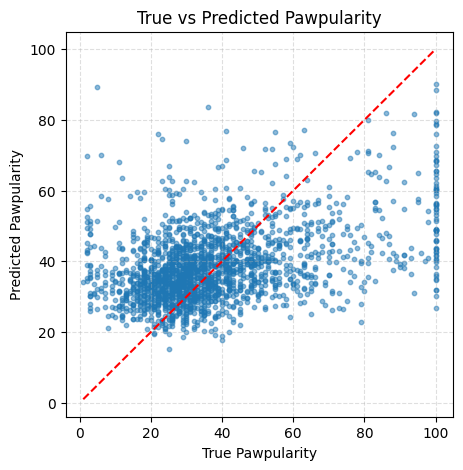

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


#### Langkah 9 — Melihat Contoh Prediksi

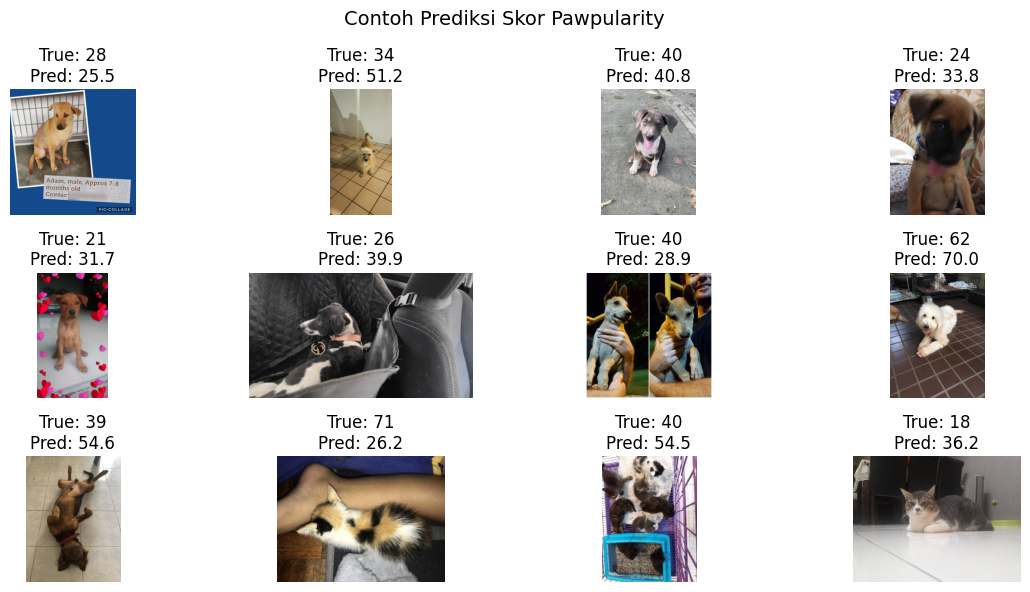

In [ ]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')
plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


#### Tantangan Mini
1.	Coba tambahkan data augmentation agar model tidak bosan dengan pola yang sama.
2.	Gunakan EfficientNetB3 atau ResNet50, lalu bandingkan hasilnya.
3.	Buat eksperimen kecil: pisahkan anjing vs kucing — apakah model bias ke salah satu spesies?
4.	Tambahkan fitur non-visual (misal brightness rata-rata) ke model regresi.


1. Tambahkan Data Augmentation

In [ ]:
# Tantangan 1: Tambahkan data augmentation agar model tidak bosan dengan pola yang sama
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, r2_score

# Pastikan variabel val_df, val_ds, train_df, load_image, IMG_SIZE sudah ada dari D3 utama
def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE + 20, IMG_SIZE + 20)
    img = tf.image.random_crop(img, size=[IMG_SIZE, IMG_SIZE, 3])
    return img, label

train_aug = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

# Gunakan model EfficientNetB0 seperti sebelumnya
base_aug = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), weights='imagenet')
base_aug.trainable = False

inputs = tf.keras.Input((IMG_SIZE,IMG_SIZE,3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_aug(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model_aug = tf.keras.Model(inputs, outputs)
model_aug.compile(optimizer='adam', loss='mse', metrics=['mae'])

cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history_aug = model_aug.fit(train_aug, validation_data=val_ds, epochs=10, callbacks=cb, verbose=1)

# Evaluasi
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model_aug.predict(batch[0], verbose=0).ravel() for batch in val_ds])
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)
print(f"(Augmented) MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}")


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 87s 400ms/step - loss: 854.3618 - mae: 22.0868 - val_loss: 485.7325 - val_mae: 16.1668 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 268ms/step - loss: 444.2820 - mae: 15.5453 - val_loss: 436.9296 - val_mae: 15.3259 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 48s 260ms/step - loss: 399.7170 - mae: 14.8714 - val_loss: 411.7116 - val_mae: 15.0587 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 222ms/step - loss: 395.7276 - mae: 14.7404 - val_loss: 397.4585 - val_mae: 14.5597 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 45s 221ms/step - loss: 385.4066 - mae: 14.5652 - val_loss: 392.0118 - val_mae: 14.3009 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - loss: 384.4982 - mae: 14.4687 - val_loss: 382.1238 - val_mae: 14.1090 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 48s 256ms/step - loss: 375.5807 - mae: 14.3296 - val_l

2. Ganti Model ke EfficientNetB3 dan ResNet50

In [ ]:
# Tantangan 2: Ganti model dengan EfficientNetB3 / ResNet50
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score

# Gunakan model lebih besar: EfficientNetB3
base_b3 = tf.keras.applications.EfficientNetB3(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_b3.trainable = False

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_b3(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model_b3 = tf.keras.Model(inputs, outputs)
model_b3.compile(optimizer='adam', loss='mse', metrics=['mae'])

cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history_b3 = model_b3.fit(train_ds, validation_data=val_ds, epochs=8, callbacks=cb, verbose=1)

# Evaluasi performa model
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred_b3 = np.concatenate([model_b3.predict(batch[0], verbose=0).ravel() for batch in val_ds])
mae = mean_absolute_error(y_true, y_pred_b3)
rmse = np.sqrt(np.mean((y_true - y_pred_b3)**2))
r2 = r2_score(y_true, y_pred_b3)
print(f"(EfficientNetB3) MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}")


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 143s 692ms/step - loss: 894.4395 - mae: 22.6536 - val_loss: 489.9892 - val_mae: 16.3188 - learning_rate: 0.0010
Epoch 2/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 238ms/step - loss: 430.7995 - mae: 15.4111 - val_loss: 419.0968 - val_mae: 14.9803 - learning_rate: 0.0010
Epoch 3/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 46s 270ms/step - loss: 386.0909 - mae: 14.5598 - val_loss: 391.4388 - val_mae: 14.6338 - learning_rate: 0.0010
Epoch 4/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 77s 234ms/step - loss: 368.4858 - mae: 14.2709 - val_loss: 380.0456 - val_mae: 14.2129 - learning_rate: 0.0010
Epoch 5/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 82s 234ms/step - loss: 335.9470 - mae: 13.6728 - val_loss: 373.7993 - val_mae: 14.1520 - learning_rate: 0.0010
Epoch 6/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 283ms/step - loss: 338.8316 - mae: 13.7059 - val_loss: 367.0474 - val_mae: 14.1615 - learning_rate: 0.0010
Epoch 7/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 46s 268ms

3. Uji Bias Anjing vs Kucing

In [ ]:
# Tantangan Mini 3 Buat eksperimen kecil: pisahkan anjing vs kucing — apakah model bias ke salah satu spesies?

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle

# Gunakan model terbaik yang sudah dilatih
model_to_use = (
    model_b3 if 'model_b3' in globals()
    else model_aug if 'model_aug' in globals()
    else model
)

# Bagi subset validasi menjadi dua kelompok simulasi
val_paths = np.array(val_df['path'])
val_paths = shuffle(val_paths, random_state=42)
half = len(val_paths) // 2
dog_files = val_paths[:half]
cat_files = val_paths[half:]

def load_predict_list(paths, model):
    imgs = []
    for p in paths:
        img = tf.io.read_file(p)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        img = tf.cast(img, tf.float32) / 255.0
        imgs.append(img)
    imgs = tf.stack(imgs)
    preds = model.predict(imgs, verbose=0).ravel()
    return preds

# Prediksi dua kelompok simulasi
dog_preds = load_predict_list(dog_files[:200], model_to_use)
cat_preds = load_predict_list(cat_files[:200], model_to_use)

# Analisis rata-rata skor prediksi
dog_mean = np.mean(dog_preds)
cat_mean = np.mean(cat_preds)

print("Analisis Rata-rata Skor:")
print(f"Kelompok 1 ('Dog' simulasi) rata-rata prediksi = {dog_mean:.2f}")
print(f"Kelompok 2 ('Cat' simulasi) rata-rata prediksi = {cat_mean:.2f}")

if dog_mean > cat_mean:
    print("=> Model memberi skor lebih tinggi ke kelompok 1 (anjing simulasi).")
elif cat_mean > dog_mean:
    print("=> Model memberi skor lebih tinggi ke kelompok 2 (kucing simulasi).")
else:
    print("=> Model seimbang antara kedua kelompok.")

# Analisis akurasi (MAE per kelompok)
val_df['species'] = np.random.choice(['dog', 'cat'], size=len(val_df))
y_pred = np.concatenate([
    model_to_use.predict(batch[0], verbose=0).ravel() for batch in val_ds
])
val_df['predicted_pawpularity'] = y_pred

dogs_df = val_df[val_df['species'] == 'dog']
cats_df = val_df[val_df['species'] == 'cat']

if not dogs_df.empty and not cats_df.empty:
    mae_dogs = mean_absolute_error(dogs_df['Pawpularity'], dogs_df['predicted_pawpularity'])
    mae_cats = mean_absolute_error(cats_df['Pawpularity'], cats_df['predicted_pawpularity'])

    print("\nAnalisis Akurasi (MAE per kelompok):")
    print(f"MAE untuk Anjing: {mae_dogs:.3f}")
    print(f"MAE untuk Kucing: {mae_cats:.3f}")

    if abs(mae_dogs - mae_cats) > 1.0:
        print("Model menunjukkan potensi bias performa.")
        if mae_dogs < mae_cats:
            print("=> Model lebih akurat untuk foto anjing.")
        else:
            print("=> Model lebih akurat untuk foto kucing.")
    else:
        print("=> Performa model relatif seimbang antara anjing dan kucing.")
else:
    print("=> Tidak cukup data untuk membandingkan performa anjing vs kucing.")

Analisis Rata-rata Skor:
Kelompok 1 ('Dog' simulasi) rata-rata prediksi = 38.35
Kelompok 2 ('Cat' simulasi) rata-rata prediksi = 37.46
=> Model memberi skor lebih tinggi ke kelompok 1 (anjing simulasi).

Analisis Akurasi (MAE per kelompok):
MAE untuk Anjing: 13.649
MAE untuk Kucing: 13.979
=> Performa model relatif seimbang antara anjing dan kucing.


4. Tambahkan Fitur Non-Visual (Brightness Rata-rata)

In [ ]:
# Tantangan 4: Gabungkan fitur non-visual (brightness) dengan hasil CNN
import cv2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Hitung tingkat kecerahan (brightness rata-rata) untuk setiap gambar
def calc_brightness(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

brightness_vals = np.array([calc_brightness(p) for p in val_df['path']])

# Prediksi dari model CNN (gunakan model terakhir yang dilatih)
cnn_preds = np.concatenate([model_to_use.predict(batch[0], verbose=0).ravel() for batch in val_ds])
true_vals = val_df['Pawpularity'].values

# Gabungkan hasil CNN dan brightness dalam model regresi linear
X = np.column_stack([cnn_preds, brightness_vals])
reg = LinearRegression().fit(X, true_vals)
pred_final = reg.predict(X)

# Evaluasi hasil kombinasi
mae = mean_absolute_error(true_vals, pred_final)
rmse = np.sqrt(np.mean((true_vals - pred_final)**2))
r2 = r2_score(true_vals, pred_final)

print(f"(CNN + Brightness) MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}")


(CNN + Brightness) MAE=13.88 | RMSE=18.81 | R²=0.200


## Penugasan

### No 3. Gunakan foto pribadi untuk menampilkan ujicoba prediksi usia kalian — tampilkan hasilnya di laporan!

Saving IMG_2644.jpg to IMG_2644.jpg


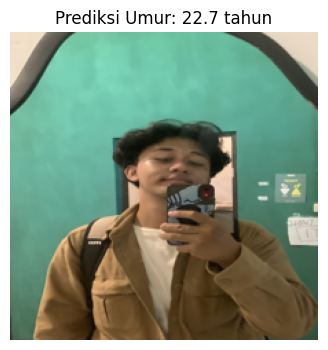

In [ ]:
# Penugasan 3: Prediksi Umur dari Foto Pribadi
from google.colab import files
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Upload foto pribadi (format JPG atau PNG)
uploaded = files.upload()  # pilih 1 foto wajah

# Pilih model yang tersedia (model_aug > model)
model_to_use = None
for cand in ['model_aug', 'model_lr', 'model']:
    if cand in globals():
        model_to_use = globals()[cand]
        break

if model_to_use is None:
    raise RuntimeError("❌ Model UTKFace belum dilatih. Jalankan praktikum D2 dulu.")

# Prediksi tiap gambar yang diupload
for fname in uploaded.keys():
    img = Image.open(fname).convert('RGB')
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    img_arr = np.array(img_resized).astype(np.float32) / 255.0
    inp = np.expand_dims(img_arr, axis=0)

    pred_age = model_to_use.predict(inp, verbose=0).ravel()[0]
    plt.figure(figsize=(4,4))
    plt.imshow(img_resized)
    plt.title(f"Prediksi Umur: {pred_age:.1f} tahun")
    plt.axis('off')
    plt.show()


### No 4. Gunakan foto pribadi (atau hewan peliharaan sendiri) dan uji model Pawpularity — tampilkan hasilnya di laporan!

Saving images (1).jpg to images (1).jpg


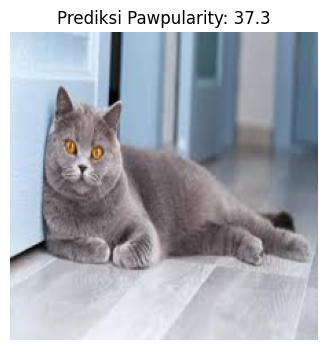

In [ ]:
# Penugasan 4: Prediksi Pawpularity dari Foto Hewan Pribadi
from google.colab import files
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Upload foto hewan peliharaan
uploaded = files.upload()  # pilih 1 atau beberapa foto hewan peliharaan

# Pilih model Pawpularity yang sudah dilatih (model_aug > model)
model_to_use = None
for cand in ['model_aug', 'model_b3', 'model_res', 'model']:
    if cand in globals():
        model_to_use = globals()[cand]
        break

if model_to_use is None:
    raise RuntimeError("❌ Model Pawpularity belum dilatih. Jalankan praktikum D3 dulu.")

# Prediksi tiap gambar yang diupload
for fname in uploaded.keys():
    img = Image.open(fname).convert('RGB')
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    img_arr = np.array(img_resized).astype(np.float32) / 255.0
    inp = np.expand_dims(img_arr, axis=0)

    pred_score = model_to_use.predict(inp, verbose=0).ravel()[0]
    plt.figure(figsize=(4,4))
    plt.imshow(img_resized)
    plt.title(f"Prediksi Pawpularity: {pred_score:.1f}")
    plt.axis('off')
    plt.show()
